# ABSEHRD package demo
This notebook demonstrates Automated Brewering Synthetic Electronic Health Record Data (ABSEHRD) package functionality on a toy dataset.

## Setup

### Import python and ABSEHRD modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split

from preprocessor import preprocessor
from corgan import corgan
from realism import realism
from privacy import privacy

### Set parameters for the toy dataset and demo

In [16]:
# toy dataset
n = 10000
count_min = 5
count_max = 19
constant_value = 'helloworld'
binary_A = 'A'
binary_B = 'B'
categorical_values = ['X','Y','Z']

# synthetic data generation and validation
n_gen = round(n/2)
outcome = 'binary01'

# sehrd objects
pre = preprocessor(missing_value=-99999)
rea = realism()
pri = privacy()
cor = corgan()

### Generate the toy dataset

In [3]:
names = ['constant','binary01', 'binaryAB', 'categorical','count','continuous']
v_constant = np.full(shape=n, fill_value=constant_value)
v_binary01 = np.random.randint(low=0, high=2, size=n)
v_binaryAB = np.concatenate((np.full(shape=n-1, fill_value=binary_A), np.array([binary_B])))
v_categorical = np.random.choice(categorical_values, size=n)
v_count = np.random.randint(low=count_min, high=count_max+1, size=n)
v_continuous = np.random.random(size=n)
x = np.column_stack((v_constant, v_binary01, v_binaryAB, v_categorical, v_count, v_continuous))
print(x)

[['helloworld' '1' 'A' 'Z' '19' '0.885943744109407']
 ['helloworld' '1' 'A' 'Z' '11' '0.2219293367937306']
 ['helloworld' '0' 'A' 'X' '8' '0.21600626626574904']
 ...
 ['helloworld' '1' 'A' 'Y' '13' '0.2954809236981648']
 ['helloworld' '0' 'A' 'Z' '15' '0.5313304553590602']
 ['helloworld' '1' 'B' 'X' '18' '0.8013218184713552']]


### Split into training and testing set

In [4]:
n_subset = round(len(x) * 0.5)
idx_trn = np.random.choice(len(x), n_subset, replace=False)
idx_tst = np.setdiff1d(range(len(x)), idx_trn)
x_trn = x[idx_trn,:]
x_tst = x[idx_tst,:]

print('Number of training samples: '+str(len(x_trn)))
print('Number of testing samples: '+str(len(x_tst)))

Number of training samples: 5000
Number of testing samples: 5000


## Preprocessing

### Save metadata for restoring data format after synthetic data generation

In [5]:
m = pre.get_metadata(x=x_trn, header=names)
print('var_name, var_type, min, max, zero, one, unique, missing')
print(m)

var_name, var_type, min, max, zero, one, unique, missing
[('constant', 'constant', 0.00000000e+00,  0.       , 'helloworld', '', '', False)
 ('binary01', 'binary', 0.00000000e+00,  0.       , '1', '0', '', False)
 ('binaryAB', 'binary', 0.00000000e+00,  0.       , 'A', 'B', '', False)
 ('categorical', 'categorical', 0.00000000e+00,  0.       , '', '', 'X,Y,Z', False)
 ('count', 'count', 5.00000000e+00, 19.       , '', '', '', False)
 ('continuous', 'continuous', 1.37901428e-04,  0.9998291, '', '', '', False)]


### Encode raw data matrix in preparation for training synthetic data generator
Note that count and continuous variables have been scaled between 0 and 1 while constant, categorical, and binary have been one-hot encoded.

In [6]:
d = pre.get_discretized_matrix(x_trn, m, names)
print('Formatted matrix:')
print(d['x'])
print('\nHeader for formatted matrix:')
print(d['header'])

Formatted matrix:
[[0.         0.         1.         ... 0.         0.87804143 0.        ]
 [0.         0.         0.         ... 0.         0.09351324 0.        ]
 [0.         0.         0.         ... 0.         0.08564701 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.83606231 0.        ]
 [0.         0.         0.         ... 0.         0.67987786 0.        ]
 [0.         0.         1.         ... 0.         0.63591133 0.        ]]

Header for formatted matrix:
['constant__constant' 'constant__-99999' 'binary01__binary01'
 'binary01__-99999' 'binaryAB__binaryAB' 'binaryAB__-99999'
 'categorical__0' 'categorical__1' 'categorical__2' 'categorical__3'
 'count__count' 'count__-99999' 'continuous__continuous'
 'continuous__-99999']


## Generation

### Train CorGAN model 

In [7]:
model = cor.train(x=d['x'], n_cpu=1, debug=True)

[Epoch 1/100 of pretraining] [Batch 0/5000] [A loss: 10.262]
[Epoch 2/100 of pretraining] [Batch 0/5000] [A loss: 9.397]
[Epoch 3/100 of pretraining] [Batch 0/5000] [A loss: 8.604]
[Epoch 4/100 of pretraining] [Batch 0/5000] [A loss: 7.891]
[Epoch 5/100 of pretraining] [Batch 0/5000] [A loss: 7.108]
[Epoch 6/100 of pretraining] [Batch 0/5000] [A loss: 6.434]
[Epoch 7/100 of pretraining] [Batch 0/5000] [A loss: 5.749]
[Epoch 8/100 of pretraining] [Batch 0/5000] [A loss: 5.134]
[Epoch 9/100 of pretraining] [Batch 0/5000] [A loss: 4.616]
[Epoch 10/100 of pretraining] [Batch 0/5000] [A loss: 4.160]
[Epoch 11/100 of pretraining] [Batch 0/5000] [A loss: 3.820]
[Epoch 12/100 of pretraining] [Batch 0/5000] [A loss: 3.509]
[Epoch 13/100 of pretraining] [Batch 0/5000] [A loss: 3.315]
[Epoch 14/100 of pretraining] [Batch 0/5000] [A loss: 3.073]
[Epoch 15/100 of pretraining] [Batch 0/5000] [A loss: 2.872]
[Epoch 16/100 of pretraining] [Batch 0/5000] [A loss: 2.743]
[Epoch 17/100 of pretraining] [B

It has been 0.41 seconds for this epoch
TRAIN: [Epoch 10/100] [Batch 6/4000] Loss_D: -0.110 Loss_G: -0.059 Loss_D_real: 0.057 Loss_D_fake -0.053
TEST: [Epoch 10/100] [Batch 6/4000] [A loss: 1.05] [real accuracy: 100.00] [fake accuracy: 61.91]
It has been 0.41 seconds for this epoch
TRAIN: [Epoch 11/100] [Batch 6/4000] Loss_D: -0.085 Loss_G: -0.027 Loss_D_real: 0.054 Loss_D_fake -0.031
TEST: [Epoch 11/100] [Batch 6/4000] [A loss: 1.04] [real accuracy: 99.80] [fake accuracy: 66.21]
It has been 0.42 seconds for this epoch
TRAIN: [Epoch 12/100] [Batch 6/4000] Loss_D: -0.076 Loss_G: -0.012 Loss_D_real: 0.053 Loss_D_fake -0.024
TEST: [Epoch 12/100] [Batch 6/4000] [A loss: 1.04] [real accuracy: 99.61] [fake accuracy: 57.62]
It has been 0.42 seconds for this epoch
TRAIN: [Epoch 13/100] [Batch 6/4000] Loss_D: -0.062 Loss_G: -0.008 Loss_D_real: 0.044 Loss_D_fake -0.018
TEST: [Epoch 13/100] [Batch 6/4000] [A loss: 1.05] [real accuracy: 89.45] [fake accuracy: 57.03]
It has been 0.42 seconds for th

TRAIN: [Epoch 44/100] [Batch 6/4000] Loss_D: -0.018 Loss_G: 0.008 Loss_D_real: 0.013 Loss_D_fake -0.005
TEST: [Epoch 44/100] [Batch 6/4000] [A loss: 1.01] [real accuracy: 84.38] [fake accuracy: 56.84]
It has been 0.41 seconds for this epoch
TRAIN: [Epoch 45/100] [Batch 6/4000] Loss_D: -0.017 Loss_G: 0.005 Loss_D_real: 0.013 Loss_D_fake -0.004
TEST: [Epoch 45/100] [Batch 6/4000] [A loss: 1.03] [real accuracy: 89.26] [fake accuracy: 46.09]
It has been 0.41 seconds for this epoch
TRAIN: [Epoch 46/100] [Batch 6/4000] Loss_D: -0.011 Loss_G: 0.013 Loss_D_real: 0.009 Loss_D_fake -0.002
TEST: [Epoch 46/100] [Batch 6/4000] [A loss: 1.04] [real accuracy: 94.34] [fake accuracy: 39.65]
It has been 0.41 seconds for this epoch
TRAIN: [Epoch 47/100] [Batch 6/4000] Loss_D: -0.011 Loss_G: 0.014 Loss_D_real: 0.014 Loss_D_fake 0.003
TEST: [Epoch 47/100] [Batch 6/4000] [A loss: 1.02] [real accuracy: 96.48] [fake accuracy: 29.30]
It has been 0.42 seconds for this epoch
TRAIN: [Epoch 48/100] [Batch 6/4000] 

TEST: [Epoch 78/100] [Batch 6/4000] [A loss: 1.04] [real accuracy: 84.18] [fake accuracy: 33.79]
It has been 0.42 seconds for this epoch
TRAIN: [Epoch 79/100] [Batch 6/4000] Loss_D: -0.002 Loss_G: 0.013 Loss_D_real: 0.011 Loss_D_fake 0.009
TEST: [Epoch 79/100] [Batch 6/4000] [A loss: 1.04] [real accuracy: 100.00] [fake accuracy: 3.91]
It has been 0.43 seconds for this epoch
TRAIN: [Epoch 80/100] [Batch 6/4000] Loss_D: -0.007 Loss_G: 0.009 Loss_D_real: 0.013 Loss_D_fake 0.006
TEST: [Epoch 80/100] [Batch 6/4000] [A loss: 1.02] [real accuracy: 100.00] [fake accuracy: 17.19]
It has been 0.43 seconds for this epoch
TRAIN: [Epoch 81/100] [Batch 6/4000] Loss_D: -0.009 Loss_G: 0.007 Loss_D_real: 0.015 Loss_D_fake 0.005
TEST: [Epoch 81/100] [Batch 6/4000] [A loss: 1.04] [real accuracy: 100.00] [fake accuracy: 13.67]
It has been 0.44 seconds for this epoch
TRAIN: [Epoch 82/100] [Batch 6/4000] Loss_D: -0.009 Loss_G: 0.009 Loss_D_real: 0.015 Loss_D_fake 0.006
TEST: [Epoch 82/100] [Batch 6/4000] [A

### Generate synthetic samples

In [17]:
s = cor.generate(model, n_gen)
print(s)

[[1.07840006e-03 5.35098196e-04 1.08331613e-01 ... 9.14475939e-04
  7.43671834e-01 3.35581368e-04]
 [4.90676053e-03 3.28933634e-03 1.21717349e-01 ... 1.02419173e-03
  1.43618852e-01 9.19473998e-04]
 [3.61698749e-03 1.70215522e-03 1.42049219e-03 ... 1.23420113e-03
  8.84088650e-02 1.31964072e-04]
 ...
 [7.68776797e-03 1.81375491e-03 3.32754590e-02 ... 1.00610852e-02
  4.17064935e-01 4.65348642e-03]
 [2.61984416e-03 9.55473806e-04 3.64197381e-02 ... 1.72784354e-03
  2.28183288e-02 4.06074774e-04]
 [9.04165034e-04 5.04107855e-04 5.86730803e-11 ... 1.03617704e-03
  1.87731802e-01 1.73939086e-04]]


### Use metadata to restore original formatting

In [18]:
f = pre.restore_matrix(x=s, m=m, header=d['header'])
print('Synthetic samples:')
print(f['x'])
print('\nReal samples:')
print(x)

Synthetic samples:
[['helloworld' '1' 'A' 'Z' '5.0' '0.7435800903811678']
 ['helloworld' '1' 'A' 'Z' '8.0' '0.1437124038935224']
 ['helloworld' '1' 'A' 'Y' '5.0' '0.0885194658461908']
 ...
 ['helloworld' '1' 'A' 'Y' '18.0' '0.4170740469394797']
 ['helloworld' '1' 'A' 'X' '13.0' '0.022949183951316603']
 ['helloworld' '1' 'A' 'X' '16.0' '0.18781173239839768']]

Real samples:
[['helloworld' '1' 'A' 'Z' '19' '0.885943744109407']
 ['helloworld' '1' 'A' 'Z' '11' '0.2219293367937306']
 ['helloworld' '0' 'A' 'X' '8' '0.21600626626574904']
 ...
 ['helloworld' '1' 'A' 'Y' '13' '0.2954809236981648']
 ['helloworld' '0' 'A' 'Z' '15' '0.5313304553590602']
 ['helloworld' '1' 'B' 'X' '18' '0.8013218184713552']]


## Realism

### Compare univariate frequency for real and synthetic features

In [19]:
res_uni = rea.validate_univariate(r=d['x'], s=s, header=d['header'])
corr_uni = np.corrcoef(x=res_uni['frq_r'], y=res_uni['frq_s'])[0,1]
print('Correlation between feature frequencies =',np.round(corr_uni,2))

Correlation between feature frequencies = 0.97


Plot the synthetic and real feature frequencies for each feature...

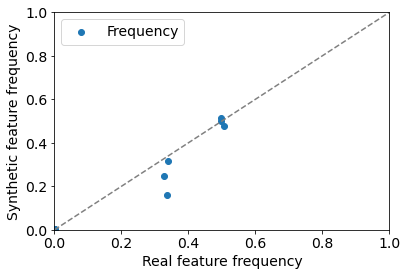

In [20]:
fontsize = 14
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1],[0,1], color="gray", linestyle='--')
ax1.scatter(res_uni['frq_r'], res_uni['frq_s'], label='Frequency')
ax1.set_xlabel('Real feature frequency', fontsize=fontsize)
ax1.set_ylabel('Synthetic feature frequency', fontsize=fontsize)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.tick_params(axis='x', labelsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)
ax1.legend(fontsize=fontsize)

### Compare predictive performance
* Real: use real dataset to train predictive model and test on a separate real dataset
* GAN-train: use synthetic dataset to train predictive model and test on a real dataset
*GAN-test: use real dataset to train predictive model and test on the synthetic dataset

In [21]:
print('Extract outcome \'', outcome,'\' from real and synthetic datasets', sep='')
print('\nHeader:')
print(d['header'])

Extract outcome 'binary01' from real and synthetic datasets

Header:
['constant__constant' 'constant__-99999' 'binary01__binary01'
 'binary01__-99999' 'binaryAB__binaryAB' 'binaryAB__-99999'
 'categorical__0' 'categorical__1' 'categorical__2' 'categorical__3'
 'count__count' 'count__-99999' 'continuous__continuous'
 'continuous__-99999']


In [22]:
r = d['x']

idx_outcome = np.where(d['header'] == outcome+'__'+outcome)
y_r = np.reshape(np.round(np.reshape(r[:,idx_outcome], newshape=(len(r),1))).astype(int), len(r))
y_s = np.reshape(np.round(np.reshape(s[:,idx_outcome], newshape=(len(s),1))).astype(int), len(s))
x_r = np.delete(r, idx_outcome, axis=1)
x_s = np.delete(s, idx_outcome, axis=1)

print('Real dataset dimensions:',x_r.shape)
print('Synthetic dataset dimensions:',x_s.shape)

Real dataset dimensions: (5000, 13)
Synthetic dataset dimensions: (5000, 13)


Train model for each validation test

In [23]:
n_epoch = 20
model_type='lr'

res_gan_real = rea.gan_train(x_r, y_r, x_r, y_r, n_epoch=n_epoch, model_type=model_type)
res_gan_train = rea.gan_train(x_s, y_s, x_r, y_r, n_epoch=n_epoch, model_type=model_type)
res_gan_test = rea.gan_test(x_s, y_s, x_r, y_r, n_epoch=n_epoch, model_type=model_type)

Plot resulting ROC curves

Text(0, 0.5, 'True positive rate')

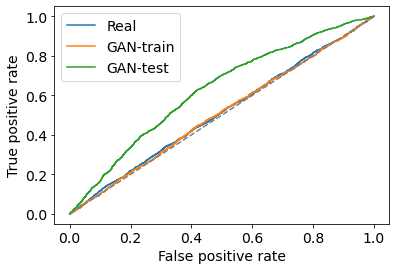

In [24]:
fontsize = 14
fig, ax3 = plt.subplots(1,1)
ax3.plot(res_gan_real['roc'][0], res_gan_real['roc'][1], label="Real")
ax3.plot(res_gan_train['roc'][0], res_gan_train['roc'][1], label="GAN-train")
ax3.plot(res_gan_test['roc'][0], res_gan_test['roc'][1], label="GAN-test")
ax3.plot([0,1],[0,1], color="gray", linestyle='--')
ax3.tick_params(axis='x', labelsize=fontsize)
ax3.tick_params(axis='y', labelsize=fontsize)
ax3.legend(fontsize=fontsize)
ax3.set_xlabel('False positive rate', fontsize=fontsize)
ax3.set_ylabel('True positive rate', fontsize=fontsize)

## Privacy

## Nearest neighbors
Ensure that synthetic dataset is not a copy of the real dataset by comparing distances between pairs of real and synthetic samples
* Real-real: distance between randomly selected pairs of real samples
* Real-synthetic: distance between pairs of real and synthetic samples
* Real-probabilistic: distance between a real sample and sampled binary vector where each column is sampled from a binomial where the frequency equals that in the real training set
* Real-random: distance between a real sample and a randomly sampled binary vector

In [26]:
n_nn_sample = 100
dist_metric = 'euclidean'
n_decimal=2

idx_r = np.random.randint(low=0, high=len(r), size=min((len(r), n_nn_sample)))
idx_s = np.random.randint(low=0, high=len(s), size=min((len(s), n_nn_sample)))
res_nn = pri.assess_memorization(r[idx_r,:], s[idx_s,:], metric=dist_metric)

print('Mean nearest neighbor distance: ')
print('  > Real-real:\t\t'+str(np.round(np.mean(res_nn['real']),n_decimal)))
print('  > Real-synthetic:\t'+str(np.round(np.mean(res_nn['synth']),n_decimal)))
print('  > Real-probabilistic: '+str(np.round(np.mean(res_nn['prob']),n_decimal)))
print('  > Real-random:\t'+str(np.round(np.mean(res_nn['rand']),n_decimal)))

Mean nearest neighbor distance: 
  > Real-real:		0.14
  > Real-synthetic:	0.38
  > Real-probabilistic: 0.46
  > Real-random:	1.67


Plot distributions for nearest neighbor distances

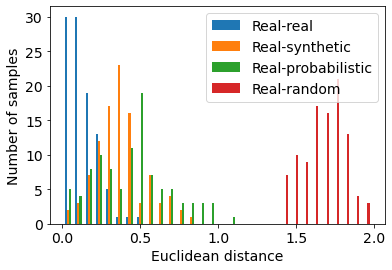

In [27]:
fontsize = 14
fig, ax2 = plt.subplots(1,1)
ax2.hist((res_nn['real'], res_nn['synth'], 
          res_nn['prob'], res_nn['rand']),
         bins=30, 
         label = ['Real-real','Real-synthetic','Real-probabilistic','Real-random'])
ax2.set_xlabel(dist_metric.capitalize()+' distance', fontsize=fontsize)
ax2.set_ylabel('Number of samples', fontsize=fontsize)
ax2.tick_params(axis='x', labelsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)
ax2.legend(fontsize=fontsize)
